In [1]:
library(readxl)
library(data.table)
library(ggplot2)
library(ggprism)
library(ggforce)
library(ggetho)
library(ggsignif)
library(zoo)
theme_set(theme_prism(base_size=20))
options(repr.plot.width=15, repr.plot.height=15)
source("R/plot.R")
source("R/Cbind.R")
source("R/link_idoc_metadata.R")
source("R/library.R")


Loading required package: behavr


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




This notebook reads the IDOC results stored in "IDOC_METHODS_PAPER_METADATA.xlsx" and produces a csv file with the data in tidy format

* Fly_group_experiment_treatment: experimental information of the fly 
* fly_name_reference: unique animal identifier, built as follows: date_time(scientist_suffix)_ROI_X
* experiment: type of memory evaluated (20min STM, 1h STM, LTM, LTM CHX, ...)
* id
* test: (PI is read PRE or POST conditioning)
* PI: (value of PI)
* Training_session: how many times CS-US pairing is presented
* Genotype: genotype of the fly
* interval: NONE, or ZTX-ZTY if the fly was SD'd between ZT X and ZT Y
* ZT4,ZT4.5,ZT5,ZT5.5,ZT6,ZT6.5,ZT7,ZT7.5,ZT8,ZT8.5,ZT9,ZT9.5,ZT10,ZT10.5,ZT11,ZT11.5,ZT12,ZT12.5,ZT13,ZT13.5,ZT14,ZT14.5,ZT15,ZT15.5,ZT16,ZT16.5,ZT17,ZT17.5,ZT18,ZT18.5,ZT19,ZT19.5,ZT20,ZT20.5,ZT21,ZT21.5,ZT22,ZT22.5,ZT23,ZT23.5,ZT24,ZT24.5,ZT25,ZT25.5,ZT26,ZT26.5,ZT27,ZT27.5,ZT28,ZT28.5,ZT29,ZT29.5,ZT30
* ZT4_interactions,ZT4.5_interactions,ZT5_interactions,ZT5.5_interactions,ZT6_interactions,ZT6.5_interactions,ZT7_interactions,ZT7.5_interactions,ZT8_interactions,ZT8.5_interactions,ZT9_interactions,ZT9.5_interactions,ZT10_interactions,ZT10.5_interactions,ZT11_interactions,ZT11.5_interactions,ZT12_interactions,ZT12.5_interactions,ZT13_interactions,ZT13.5_interactions,ZT14_interactions,ZT14.5_interactions,ZT15_interactions,ZT15.5_interactions,ZT16_interactions,ZT16.5_interactions,ZT17_interactions,ZT17.5_interactions,ZT18_interactions,ZT18.5_interactions,ZT19_interactions,ZT19.5_interactions,ZT20_interactions,ZT20.5_interactions,ZT21_interactions,ZT21.5_interactions,ZT22_interactions,ZT22.5_interactions,ZT23_interactions,ZT23.5_interactions,ZT24_interactions,ZT24.5_interactions,ZT25_interactions,ZT25.5_interactions,ZT26_interactions,ZT26.5_interactions,ZT27_interactions,ZT27.5_interactions,ZT28_interactions,ZT28.5_interactions,ZT29_interactions,ZT29.5_interactions,ZT30_interactions
User


In [2]:
idoc_dir <- "/idoc_data/results/IDOC/"


In [3]:
database <- "/idoc_data/paper/CHuiData.ods"
sheets <- readODS::list_ods_sheets(database)
columns <- c(
    "Files", "Genotype", "ROI", "Gender", "Age", "ATR", "Training",
    "Odor", "Sugar", "Electric shock",  "PRE", "PRE_1", "PRE_2", "POST", "POST_1", "POST_2", "Keep",
    "fly_name_reference", "experiment"
)
metadata_ch <- read_idoc_metadata(file = database, sheets=sheets, columns = columns, backend=readODS::read_ods)
metadata_ch$SD_quality <- "NONE"
metadata_ch$SD_quality_second_eye <- "NONE"
metadata_ch$interactor_time_window <- "NONE"
metadata_ch$interactor <- "No_stimulator"
metadata_ch$`comment on SD` <- NA
metadata_ch$User <- "CH"
metadata_ch$region_id <- "NONE"

In [4]:
table(metadata_ch$experiment)


         20min STM 20min STM unpaired           24hr LTM       24hr LTM CHX 
               210                100                247                130 

In [5]:
database <- "idoc_metadata.ods"
sheets <- c("20min_STM", "1hr_STM", "3hr_STM")
columns <- c(
    "Files", "Genotype", "ROI", "User", "fly_name_reference", "Gender", "Age", "ATR", "Training",
    "Odor", "Sugar", "Electric shock",  "PRE", "PRE_1", "PRE_2", "POST", "POST_1", "POST_2", "Keep",
    "SD_quality", "SD_quality_second_eye", "interactor_time_window", "interactor", "comment on SD", "experiment"
)

## Read STM experiments

In [6]:
metadata_stm <- read_idoc_metadata(file = database, sheets=sheets, columns = columns, backend=readODS::read_ods)
# STM flies don't go to the ethoscope, so region_id is NONE
metadata_stm$region_id <- "NONE"

Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Deleting 21 42 63 82 103 124 145 166 rows from metadata”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Deleting 21 42 63 rows from metadata”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Deleting 21 42 63 84 105 126 rows from metadata”


In [7]:
metadata_ltm <- read_idoc_metadata(file = database, sheets=c("24hr_LTM"), columns = c(columns, "region_id"), backend=readODS::read_ods)
# keep either NS or good SD flies, (discard bad SD flies) 
metadata_ltm <- metadata_ltm[SD_quality %in% c("No_sleep_depriver", "good") & SD_quality_second_eye %in% c("No_sleep_depriver", "good"),]
metadata_ltm[SD_quality=="No_sleep_depriver", SD_quality := "NONE"]
metadata_ltm[SD_quality_second_eye=="No_sleep_depriver", SD_quality_second_eye := "NONE"]


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“NAs introduced by coercion”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“NAs introduced by coercion”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Deleting 20 38 58 79 100 117 128 139 150 161 172 183 194 205 216 227 238 249 259 270 281 292 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 357 368 379 390 401 rows from metadata”


In [8]:
metadata_gtacr <- read_idoc_metadata(file = database, sheets=c("24hr_LTM_GTACR"), columns =  c(columns, "region_id"), backend=readODS::read_ods)
metadata_gtacr[SD_quality=="No_sleep_depriver", SD_quality := "NONE"]
metadata_gtacr[SD_quality_second_eye=="No_sleep_depriver", SD_quality_second_eye := "NONE"]


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“NAs introduced by coercion”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“NAs introduced by coercion”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Deleting 11 22 33 44 55 66 rows from metadata”


In [9]:
metadata <- rbind(metadata_stm, metadata_ltm, metadata_gtacr, metadata_ch)

In [10]:
metadata_linked <- link_idoc_metadata(metadata, result_dir="/idoc_data/IDOC", verbose=FALSE)
n_missing_animals <- nrow(metadata_linked[is.na(idoc_folder),])
if (n_missing_animals>0) {
    warning(paste(n_missing_animals, "animals could not be linked"))
}

In [11]:
metadata_linked <- metadata_linked[!is.na(idoc_folder),]
metadata_linked[, PRE_manual := PRE]
metadata_linked[, POST_manual := POST]

In [12]:
# use raw csv

data <- load_idoc_data(
    metadata_linked,
    # how many exits need to happen for the trial to be considered?
    min_exits=3,
    # load from trial 1 and trial 2, applying the min_exit requirement to each separately
    trials=1:2
)
# use chui annotation in excel file
# data <- data.table::copy(metadata_linked)

In [13]:
hits <- data[, .(Files, idoc_folder, User, PRE_found=sapply(PRE_files, function(x) {!any(is.na(x))}), POST_found=sapply(POST_files, function(x) {!any(is.na(x))}))]

In [14]:
data[,PRE_machine := PRE]
data[,PRE_1_machine := PRE_1]
data[,PRE_2_machine := PRE_2]
data[,POST_machine := PRE]
data[,POST_1_machine := POST_1]
data[,POST_2_machine := POST_2]
data[, PRE := PRE_manual]
data[, POST := POST_manual]

In [15]:
data_raw <- data.table::copy(data)

In [16]:
data<-data_raw[!is.na(POST) & !is.na(PRE),]

In [17]:
# data_raw[Genotype=="orb2", .(Files, idoc_folder, sheet, PRE, POST)]

In [18]:
data<-data[abs(PRE)<=0.2,]

In [19]:
# verify there are not repeats (the same fly represent more than once)
counts <- data[, .N, by=fly_name_reference]
stopifnot(all(counts$N==1))

In [20]:
# format interactor time window so it is either NONE or one of the ZTs
data[interactor_time_window=="No_stimulator", interactor_time_window := "NONE"]
# generate the column SD_status to summarise SD_quality and SD_quality_second_eye
data[, SD_status := "NONE"]
data[interactor_time_window!="NONE" & !(SD_quality == "good" & SD_quality_second_eye == "good"), SD_status := "bad"]
data[SD_quality == "good" & SD_quality_second_eye == "good", SD_status := "good"]
# unknown = gtacr flies
data[SD_quality == "unknown" & SD_quality_second_eye == "unknown", SD_status := "unknown"]

data[ , interval := interactor_time_window]
data[ , interactor_time_window := NULL]



In [21]:
data[, .N ,by=.(interval, SD_quality, SD_quality_second_eye, SD_status)]

interval,SD_quality,SD_quality_second_eye,SD_status,N
<chr>,<chr>,<chr>,<chr>,<int>
NONE,NONE,NONE,NONE,541
ZT05-ZT11,unknown,unknown,unknown,47
ZT05-ZT24,good,good,good,12
ZT12-ZT18,good,good,good,25
ZT05-ZT11,good,good,good,26


In [22]:
data[, SD_quality := NULL]
data[, SD_quality_second_eye := NULL]

In [23]:
data[, id := 1:.N]


In [24]:
table(data$User)


   AOJ     CH    ESB     ET ET_AOJ 
     8    353     90    189     11 

In [25]:
data_long <- melt(data = data, measure.vars = c("PRE", "POST"), value.name = "PI", variable.name = "test")
data.table::fwrite(x = data_long, file = "tidy_data.csv")
data.table::fwrite(x = data, file = "tidy_data_wide.csv")


remove all flies that don't have a PRE and POST

Warning message in plot_theme(plot):
“The `legend.text.align` theme element is not defined in the element hierarchy.”
Warning message in plot_theme(plot):
“The `legend.title.align` theme element is not defined in the element hierarchy.”


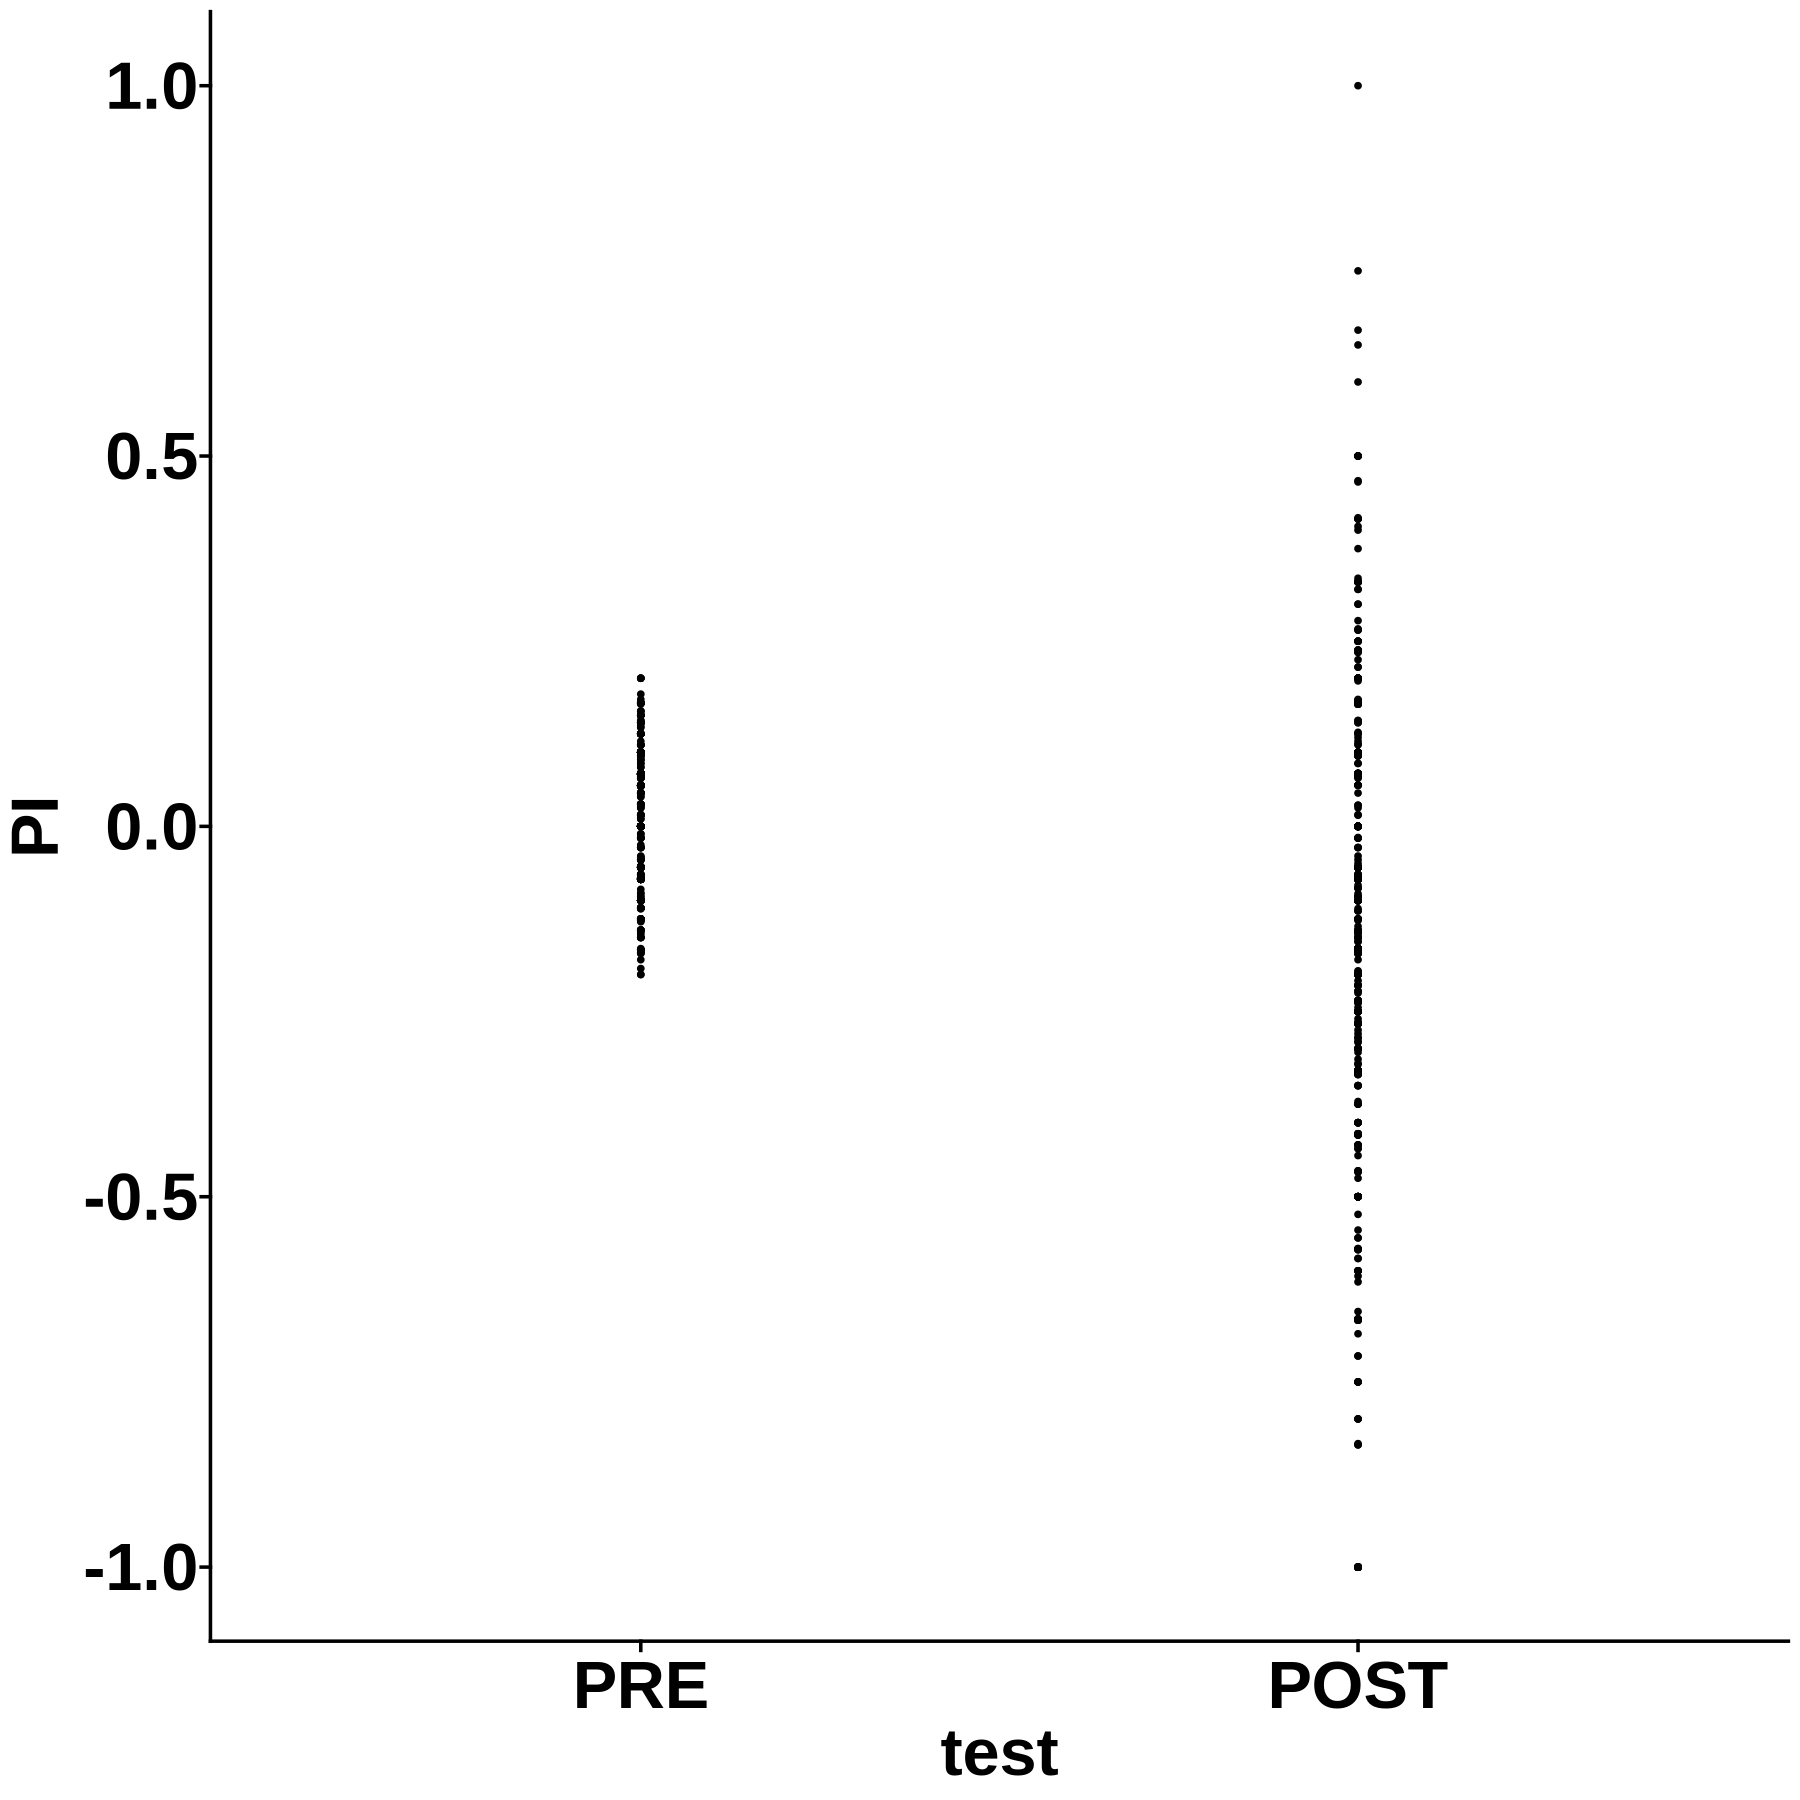

In [26]:
ggplot(data=data_long, aes(x=test, y=PI)) + geom_point()

In [27]:
data[, .(Files, idoc_folder, sheet, ROI, PRE, PRE_1, PRE_1_manual, PRE_2, PRE_2_manual, POST_1, POST_1_manual, POST_2, POST_2_manual)]
data[Genotype=="orb2", .N, by=experiment]
data(metadata_linked$interactor_time_window)
hits[, .N, by=.(PRE_found, User)][order(PRE_found),]
hits[, .N, by=.(POST_found, User)][order(POST_found),]
metadata_linked[Training=="6X_Spaced" & interactor_time_window=="No_stimulator" & region_id != "NONE" & !is.na(PRE) & !is.na(POST)]
table(metadata_linked$region_id)
data[Genotype=="orb2", .N, by=experiment]

Files,idoc_folder,sheet,ROI,PRE,PRE_1,PRE_1_manual,PRE_2,PRE_2_manual,POST_1,POST_1_manual,POST_2,POST_2_manual
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>
2021-09-30 (CH),/idoc_data/IDOC/2021-09-idoc_data/2021-09-30 (CH),KC_Odor_learning,4,0.000,NA,0,NA,0,NA,-1,NA,-0.67
2021-09-30 (CH),/idoc_data/IDOC/2021-09-idoc_data/2021-09-30 (CH),KC_Odor_learning,5,0.055,NA,-0.14,NA,0.25,NA,0.2,NA,0.14
2021-09-30 (CH),/idoc_data/IDOC/2021-09-idoc_data/2021-09-30 (CH),KC_Odor_learning,7,0.000,NA,0,NA,0,NA,-0.2,NA,-0.33
2021-09-30 (CH),/idoc_data/IDOC/2021-09-idoc_data/2021-09-30 (CH),KC_Odor_learning,8,-0.070,NA,-0.14,NA,0,NA,-0.5,NA,NA
2021-09-30 (CH),/idoc_data/IDOC/2021-09-idoc_data/2021-09-30 (CH),KC_Odor_learning,9,-0.055,NA,0,NA,-0.11,NA,0.33,NA,0.33
2021-09-30 (CH),/idoc_data/IDOC/2021-09-idoc_data/2021-09-30 (CH),KC_Odor_learning,10,-0.125,NA,-0.25,NA,0,NA,-0.5,NA,-0.5
2021-09-30 (CH),/idoc_data/IDOC/2021-09-idoc_data/2021-09-30 (CH),KC_Odor_learning,13,0.030,NA,-0.14,NA,0.2,NA,0.14,NA,0
2021-09-30 (CH),/idoc_data/IDOC/2021-09-idoc_data/2021-09-30 (CH),KC_Odor_learning,14,0.055,NA,0.11,NA,0,NA,-0.2,NA,0.2
2021-09-30 (CH),/idoc_data/IDOC/2021-09-idoc_data/2021-09-30 (CH),KC_Odor_learning,15,0.095,NA,0.33,NA,-0.14,NA,-0.6,NA,0


experiment,N
<chr>,<int>
20min STM,21
24hr LTM,22


Warning message in data(metadata_linked$interactor_time_window):
“data set ‘metadata_linked$interactor_time_window’ not found”


PRE_found,User,N
<lgl>,<chr>,<int>
FALSE,CH,687
TRUE,ESB,120
TRUE,ET,532
TRUE,AOJ,40
TRUE,ET_AOJ,21


POST_found,User,N
<lgl>,<chr>,<int>
FALSE,CH,667
TRUE,CH,20
TRUE,ESB,120
TRUE,ET,532
TRUE,AOJ,40
TRUE,ET_AOJ,21


Files,sheet,Genotype,ROI,User,fly_name_reference,Gender,Age,ATR,Training,⋯,interactor,comment on SD,experiment,row_number,region_id,folder__,sheet__,idoc_folder,PRE_manual,POST_manual
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<dbl>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
2023-07-12_14-25-09(ET_spaced_overnight),24hr_LTM,Iso31,1,ET,2023-07-12_14-25-09(ET_spaced_overnight)_ROI_1,FALSE,4,N,6X_Spaced,⋯,DefaultStimulator,NA,24hr LTM,1,1,2023-07-12_14-25-09(ET_spaced_overnight),24hr_LTM,/idoc_data/IDOC/2023-07-idoc_data/2023-07-12_14-25-09(ET_spaced_overnight),0.04444444,-0.21428571
2023-07-12_14-25-09(ET_spaced_overnight),24hr_LTM,Iso31,2,ET,2023-07-12_14-25-09(ET_spaced_overnight)_ROI_2,FALSE,4,N,6X_Spaced,⋯,DefaultStimulator,NA,24hr LTM,2,2,2023-07-12_14-25-09(ET_spaced_overnight),24hr_LTM,/idoc_data/IDOC/2023-07-idoc_data/2023-07-12_14-25-09(ET_spaced_overnight),0.00000000,0.00000000
2023-07-12_14-25-09(ET_spaced_overnight),24hr_LTM,Iso31,3,ET,2023-07-12_14-25-09(ET_spaced_overnight)_ROI_3,FALSE,4,N,6X_Spaced,⋯,DefaultStimulator,NA,24hr LTM,3,3,2023-07-12_14-25-09(ET_spaced_overnight),24hr_LTM,/idoc_data/IDOC/2023-07-idoc_data/2023-07-12_14-25-09(ET_spaced_overnight),-0.16666667,-0.15000000
2023-07-12_14-25-09(ET_spaced_overnight),24hr_LTM,Iso31,4,ET,2023-07-12_14-25-09(ET_spaced_overnight)_ROI_4,FALSE,4,N,6X_Spaced,⋯,DefaultStimulator,NA,24hr LTM,4,4,2023-07-12_14-25-09(ET_spaced_overnight),24hr_LTM,/idoc_data/IDOC/2023-07-idoc_data/2023-07-12_14-25-09(ET_spaced_overnight),0.10000000,0.00000000
2023-07-12_14-25-09(ET_spaced_overnight),24hr_LTM,Iso31,5,ET,2023-07-12_14-25-09(ET_spaced_overnight)_ROI_5,FALSE,4,N,6X_Spaced,⋯,DefaultStimulator,NA,24hr LTM,5,5,2023-07-12_14-25-09(ET_spaced_overnight),24hr_LTM,/idoc_data/IDOC/2023-07-idoc_data/2023-07-12_14-25-09(ET_spaced_overnight),0.00000000,0.00000000
2023-07-12_14-25-09(ET_spaced_overnight),24hr_LTM,Iso31,6,ET,2023-07-12_14-25-09(ET_spaced_overnight)_ROI_6,FALSE,4,N,6X_Spaced,⋯,DefaultStimulator,NA,24hr LTM,6,6,2023-07-12_14-25-09(ET_spaced_overnight),24hr_LTM,/idoc_data/IDOC/2023-07-idoc_data/2023-07-12_14-25-09(ET_spaced_overnight),0.07142857,-0.08333333
2023-07-12_14-25-09(ET_spaced_overnight),24hr_LTM,Iso31,7,ET,2023-07-12_14-25-09(ET_spaced_overnight)_ROI_7,FALSE,4,N,6X_Spaced,⋯,DefaultStimulator,NA,24hr LTM,7,7,2023-07-12_14-25-09(ET_spaced_overnight),24hr_LTM,/idoc_data/IDOC/2023-07-idoc_data/2023-07-12_14-25-09(ET_spaced_overnight),0.10000000,-0.50000000
2023-07-12_14-25-09(ET_spaced_overnight),24hr_LTM,Iso31,8,ET,2023-07-12_14-25-09(ET_spaced_overnight)_ROI_8,FALSE,4,N,6X_Spaced,⋯,DefaultStimulator,NA,24hr LTM,8,8,2023-07-12_14-25-09(ET_spaced_overnight),24hr_LTM,/idoc_data/IDOC/2023-07-idoc_data/2023-07-12_14-25-09(ET_spaced_overnight),0.10000000,-0.33000000
2023-07-12_14-25-09(ET_spaced_overnight),24hr_LTM,Iso31,9,ET,2023-07-12_14-25-09(ET_spaced_overnight)_ROI_9,FALSE,4,N,6X_Spaced,⋯,DefaultStimulator,NA,24hr LTM,9,9,2023-07-12_14-25-09(ET_spaced_overnight),24hr_LTM,/idoc_data/IDOC/2023-07-idoc_data/2023-07-12_14-25-09(ET_spaced_overnight),0.07142857,-0.33000000



   1   10   11   12   13   14   15   16   17   18   19    2   20    3    4    5 
  32    6    3   24    3   26    3   27    3   22    4    6   22   31    4   30 
   6    7    8    9 NONE 
   5   30    6   28 1085 

experiment,N
<chr>,<int>
20min STM,21
24hr LTM,22
